In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from scipy.stats import norm, rv_discrete

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The illustrative example shown in Chapter 1 of Sequential Monte Carlo Methods in Practice:

\[
    \begin{aligned}
        x_{t} &=\frac{1}{2} x_{t-1}+25 \frac{x_{t-1}}{1+x_{t-1}^{2}}+8 \cos (1.2 t)+u_{t} \\
        y_{t} &=\frac{x_{t}^{2}}{20}+v_{t} \\
    \end{aligned}
\]
where 
\[
    \begin{aligned}
        x_{0} &\sim \mathcal{N}\left(0, \sigma_{0}^{2}\right), \\
        u_{t} &\sim \mathcal{N}\left(0, \sigma_{u}^{2}\right), \\
        v_{t} &\sim \mathcal{N}\left(0, \sigma_{v}^{2}\right)
    \end{aligned}
\]
and 
\[
        \sigma_{0}^{2}=\sigma_{u}^{2}=10, \sigma_{v}^{2}=1 
\]

In [3]:
# global params
_params = {
    'sigma_0': 10,
    'sigma_u': 10,
    'sigma_v': 1
}

In [4]:
# Dynamical model 
def f(t, x_prev):
    return 0.5*x_prev + 25*x_prev/(1-x_prev**2) + 8*np.cos(1.2*t)

def g(t, x):
    return (x**2)/20

def x_update(t, x_prev):
    s = len(x_prev) if hasattr(x_prev, '__len__') else 1
    u_t = np.random.normal(loc=0, scale=_params['sigma_u'], size=s)
    return f(t, x_prev) + u_t

def y_update(t, x_now):
    s = len(x_now) if hasattr(x_now, '__len__') else 1
    v_t = np.random.normal(loc=0, scale=_params['sigma_v'], size=s)
    return g(t, x_now) + v_t

In [5]:
# Compute a trajectory
def trace(x0, times, next_x ,next_y):
    x_0t = [np.array([x0])]
    y_1t = []
    for t in times:
        x_0t.append(next_x(t, x_0t[-1])) # x_prev
        y_1t.append(next_y(t, x_0t[-1])) # x_now
    return x_0t, y_1t

<IPython.core.display.Javascript object>


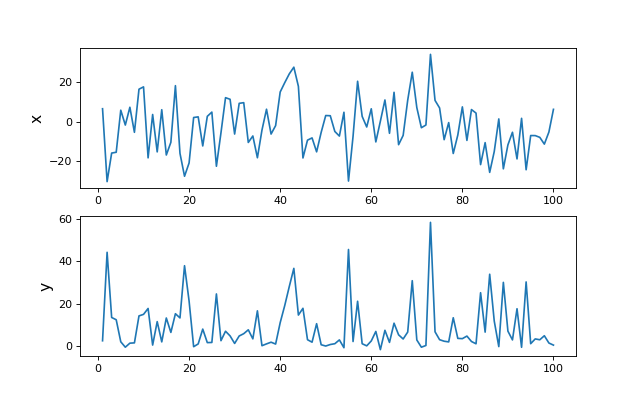

In [80]:
# Create some data
np.random.seed(20)
x0 = np.random.normal(loc=0, scale=_params['sigma_0'])
times = list(range(1, 101))

x_0t, y_1t = trace(x0, times, x_update, y_update)

fig,ax = plt.subplots(2,1,figsize=[8,5])
ax[0].plot(times, x_0t[1:])
ax[0].set_ylabel('x',fontsize=14)
ax[1].plot(times, y_1t)
ax[1].set_ylabel('y',fontsize=14)

X_hid = x_0t
Y_obs = y_1t

In [129]:
T = 100
N = 6000

# 1: Initialization
X_0t = np.array([[np.random.normal(loc=0, scale=_params['sigma_0']) for i in range(N)]])
indices = np.array(range(N))
t = 1

while(t < T):    
    # 2: Importance sampling step
    # 2a: Next time step
    X_0t = np.vstack([X_0t, x_update(t, X_0t[-1, :])])
    # 2b: Evaluate the importance weights
    W = norm(loc=0, scale=_params['sigma_v']).pdf(g(t,X_0t[-1,:]) - Y_obs[t])
    W = W/np.sum(W)
    
    # 3: Selection step
    indices = rv_discrete(values=(range(N), W)).rvs(size=N)
    X_0t = X_0t[:, indices]
    t = t + 1

<IPython.core.display.Javascript object>


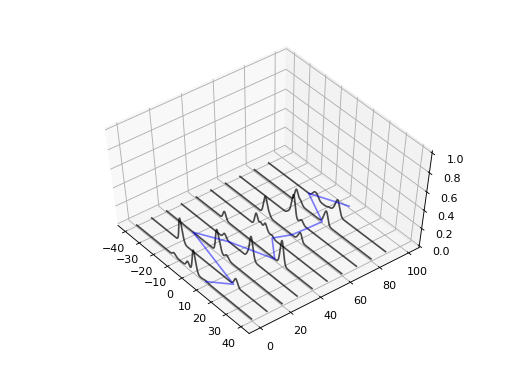

In [132]:
minX, maxX = [np.min(X_0t)-5, np.max(X_0t)+5]

fig = plt.figure()
ax = plt.axes(projection='3d')
for t in range(T):
    if t%10==0:
        xi = np.linspace(minX,maxX,N)
        xt_u, c_xt_u = np.unique(X_0t[t, :], return_counts=True)

        x_model = norm(loc=0, scale=_params['sigma_v'])
        pxi = np.sum([ct*x_model.pdf(xt - xi) for xt, ct in zip(xt_u, c_xt_u)], axis=0)/N
        ti = [t]*N
        ax.plot3D(xi, ti, pxi, 'k', alpha=0.7)
        ax.set_zlim([0,1])

# I should probably bin my ground truth to be sure
ax.plot3D(X_hid[::10], list(range(0,101))[::10], 0, 'b', alpha=0.5)